<a href="https://colab.research.google.com/github/tiagosilveiraa/portifoliods/blob/main/Recomenda%C3%A7%C3%A3o_de_Jogadores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import requests
import asyncio
from datetime import date
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
from matplotlib import rcParams
from google.colab import data_table

In [ ]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 100)
rcParams['figure.figsize'] = 20,9.27
rcParams['axes.titlesize'] = 22
rcParams['axes.labelsize'] = 16
data_table.enable_dataframe_formatter()

#1º Parametrização



In [ ]:
leagues = requests.get('https://api.sofascore.com/api/v1/config/unique-tournaments/BR/football').json()['uniqueTournaments']
seasons = []

In [ ]:
dp_leagues_data = []
dp_seasons_data = []
for l in leagues:  
  dp_leagues_data.append((l['name'], l['id']))
  s = requests.get(f'https://api.sofascore.com/api/v1/unique-tournament/{l["id"]}/seasons').json()['seasons']  
  for si in s:
    si['league'] = l['id']
    dp_seasons_data.append((si['year'], si['id'], si['league']))      

No menu abaixo selecione as ligas e temporadas que deseja obter os dados.

In [ ]:
add_button = widgets.Button(description="Adicionar")
clear_button = widgets.Button(description="Limpar Seleções")
dp_leagues = widgets.Dropdown(options=dp_leagues_data, value=None)
dp_seasons = widgets.Dropdown(value=None)
output = widgets.Output()
selected_leagues = []
selected_seasons = []

def on_change(event):
  dp_seasons_league = []
  if event['name'] == 'value':
    for ds in dp_seasons_data:
      #Busco apenas pelas seasons da liga selecionada pela posição na tupla
      if ds[2] == event['new']: 
        dp_seasons_league.append(ds[0:2])
    dp_seasons.options = dp_seasons_league

def add_league(b):
  if dp_leagues.value == None or dp_seasons.value == None:
    output.clear_output()
    print('Informações não preenchidas!')
  elif dp_leagues.value in selected_leagues and dp_seasons.value in selected_seasons:
    with output:      
      output.clear_output()
      print(f"Erro: Liga e temporada já adicionadas")       
  else:
    selected_leagues.append(dp_leagues.value)
    selected_seasons.append(dp_seasons.value) 
    output.clear_output()   
    with output:      
      print('Liga adicionada com sucesso! :D')

def clear_selection(b):
  selected_leagues.clear()
  selected_seasons.clear()
  with output:      
      print('Parâmetros reiniciados.')
      
dp_leagues.observe(on_change)
add_button.on_click(add_league)
clear_button.on_click(clear_selection)
display(dp_leagues, dp_seasons, add_button, clear_button,   output)

Dropdown(options=(('European Championship', 1), ('Copa América', 133), ('World Cup', 16), ('UEFA Champions Lea…

Dropdown(options=(), value=None)

Button(description='Adicionar', style=ButtonStyle())

Button(description='Limpar Seleções', style=ButtonStyle())

Output()

Agora selecione as posições dos jogadores que terão seus dados extraídos.

*Para selecionar mais de uma posição use as teclas CRTL ou SHIFT*

In [ ]:
dp_positions = widgets.SelectMultiple(
    options=[('Goleiros', 'G'), ('Defensores', 'D'), ('Meio-Campistas', 'M'), ('Atacantes','F')],    
    value=['G', 'D', 'M', 'F'],
    #rows=10,
    #description='Posições',
    disabled=False
)
display(dp_positions)

SelectMultiple(index=(0, 1, 2, 3), options=(('Goleiros', 'G'), ('Defensores', 'D'), ('Meio-Campistas', 'M'), (…

#2º Obtenção das estatisticas
Nesta etapa iremos utilizar os parâmetros definidos acima para capturar os dados no SofaScore

In [ ]:
def make_url_stats(competition, season, position, offset):
  return f"https://api.sofascore.com/api/v1/unique-tournament/{competition}/season/{season}/statistics?offset={offset}&order=-rating&accumulation=total&filters=position.in.{position}&fields=%2CbigChancesMissed%2CsuccessfulDribbles%2CsuccessfulDribblesPercentage%2CtotalShots%2CshotsOnTarget%2CshotsOffTarget%2CblockedShots%2CgoalConversionPercentage%2CpenaltiesTaken%2CpenaltyGoals%2CpenaltyWon%2CshotFromSetPiece%2CfreeKickGoal%2CgoalsFromInsideTheBox%2CgoalsFromOutsideTheBox%2CheadedGoals%2CleftFootGoals%2CrightFootGoal%2CshitWoodwork%2Coffsides%2CpenaltyConversion%2CsetPieceConversion%2Crating%2Cinterceptions%2CpenaltyConceded%2Cclearances%2CerrorLeadToGoal%2CerrorLeadToShot%2CownGoals%2CdribbledPast%2CcleanSheet%2C rating %2CbigChancesCreated%2Cassists %2CaccuratePasses%2CinaccuratePasses%2CtotalPasses%2CaccuratePassesPercentage %2CaccurateOwnHalfPasses%2CaccurateOppositionHalfPasses%2CaccurateFinalThirdPasses%2CkeyPasses%2CaccurateCrosses%2CaccurateCrossesPercentage%2CaccurateLongBalls%2CaccurateLongBallsPercentage%2CpassToAssist%2Crating %2CcleanSheet%2CpenaltyFaced%2CpenaltySave%2CsavedShotsFromInsideTheBox%2CsavedShotsFromOutsideTheBox%2CgoalsConcededInsideTheBox%2CgoalsConcededOutsideTheBox%2Cpunches%2CsuccessfulRunsOut%2ChighClaims%2CcrossesNotClaimed%2Crating %2CyellowCards%2CredCards%2CgroundDuelsWon%2CgroundDuelsWonPercentage%2CaerialDuelsWon%2CaerialDuelsWonPercentage%2CtotalDuelsWon%2CtotalDuelsWonPercentage%2CminutesPlayed%2CwasFouled%2Cfouls%2Cdispossessed%2CpossessionLost%2Cappearances%2CmatchesStarted%2Crating &limit=20"

In [ ]:
def get_stats(leagues, seasons, positions):
  stats = pd.DataFrame()  
  for idx, l in enumerate(leagues):    
    for p in positions:
     iw = 0
     while True:  
       response = requests.get(make_url_stats(l, seasons[idx], p, iw))
       #Já percoreu todos os players então paro
       if response.json()['results'] == []:        
         break;

       response = response.json()['results']
       response = pd.json_normalize(response, max_level=6)
       response['league'] = l      
       stats = pd.concat([stats, response])    
       iw = iw + 20 
  return stats

In [ ]:
players = get_stats(selected_leagues, selected_seasons, dp_positions.value)

In [ ]:
players

,bigChancesMissed,successfulDribbles,successfulDribblesPercentage,totalShots,shotsOnTarget,shotsOffTarget,blockedShots,goalConversionPercentage,penaltiesTaken,penaltyGoals,penaltyWon,shotFromSetPiece,freeKickGoal,goalsFromInsideTheBox,goalsFromOutsideTheBox,headedGoals,leftFootGoals,offsides,penaltyConversion,setPieceConversion,rating,interceptions,penaltyConceded,clearances,errorLeadToGoal,errorLeadToShot,ownGoals,dribbledPast,cleanSheet,bigChancesCreated,accuratePasses,inaccuratePasses,totalPasses,accurateOwnHalfPasses,accurateOppositionHalfPasses,accurateFinalThirdPasses,keyPasses,accurateCrosses,accurateCrossesPercentage,accurateLongBalls,accurateLongBallsPercentage,passToAssist,penaltyFaced,penaltySave,savedShotsFromInsideTheBox,savedShotsFromOutsideTheBox,goalsConcededInsideTheBox,goalsConcededOutsideTheBox,punches,successfulRunsOut,highClaims,crossesNotClaimed,yellowCards,redCards,groundDuelsWon,groundDuelsWonPercentage,aerialDuelsWon,aerialDuelsWonPercentage,totalDuelsWon,totalDuelsWonPercentage,minutesPlayed,wasFouled,fouls,dispossessed,possessionLost,appearances,matchesStarted,player.name,player.slug,player.userCount,player.id,team.name,team.slug,team.shortName,team.sport.name,team.sport.slug,team.sport.id,team.userCount,team.type,team.id,team.teamColors.primary,team.teamColors.secondary,team.teamColors.text,league
0,0,0,0.00,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,7.60,0,0,3,0,0,0,0,1,0,11,11,22,10,1,0,0,0,0.0,2,15.38,0,0,0,2,1,0,0,2,0,2,0,0,0,0,0.00,2,66.67,2,66.67,90,0,0,0,11,1,1,Jandrei,jandrei,347,874979,Santos,santos,Santos,Football,football,1,0,0,1968,#52b030,#52b030,#ffffff,325
1,0,0,0.00,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,7.53,0,0,5,0,0,0,1,2,0,54,62,116,29,25,3,0,0,0.0,30,32.97,0,0,0,13,6,3,1,3,1,1,1,0,0,0,0.00,1,50.00,1,33.33,360,0,0,0,63,4,4,Vinicius Silvestre,vinicius-silvestre,232,559582,Palmeiras,palmeiras,Palmeiras,Football,football,1,0,0,1963,#52b030,#52b030,#ffffff,325
2,0,0,0.00,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,7.40,0,0,0,0,0,0,0,1,0,6,0,6,6,0,0,0,0,0.0,1,100.00,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0.00,0,0.00,0,0.00,90,0,0,0,0,1,1,Matheus Donelli,matheus-donelli,401,1002609,Corinthians,corinthians,Corinthians,Football,football,1,0,0,1957,#52b030,#52b030,#ffffff,325
3,0,0,0.00,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,7.32,0,0,10,0,0,0,0,6,0,221,101,322,158,63,16,0,0,0.0,108,51.92,0,0,0,29,14,7,2,6,2,4,0,4,0,1,100.00,3,100.00,4,100.00,1125,2,0,0,102,13,13,João Ricardo,joao-ricardo,187,839761,Ceará,ceara,Ceará,Football,football,1,0,0,2001,#52b030,#52b030,#ffffff,325
4,0,1,100.00,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,7.20,4,0,30,1,3,0,1,14,0,620,272,892,499,121,27,0,0,0.0,207,43.58,0,5,0,70,71,33,3,18,6,50,0,2,0,4,80.00,7,87.50,11,84.62,3330,3,0,0,286,37,37,Mailson,mailson,350,883367,Sport Recife,sport-recife,Sport Recife,Football,football,1,0,0,1959,#52b030,#52b030,#ffffff,325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,0,0,0.00,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,6.25,1,0,0,0,0,0,1,0,0,11,6,17,5,6,3,0,0,0.0,0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,25.00,1,20.00,2,22.22,27,0,0,1,10,2,0,Matías Lacava,matias-lacava,269,1016029,Santos,santos,Santos,Football,football,1,0,0,1968,#52b030,#52b030,#ffffff,325
15,0,1,25.00,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,6.25,0,0,0,0,0,0,0,0,0,8,0,8,0,8,4,0,0,0.0,0,0.00,0,0,0,0,0,1,0,0,0,0,0,0,0,2,28.57,0,0.00,2,28.57,40,1,1,1,4,3,0,Gustavo Mantuan,gustavo-mantuan,659,1066790,Corinthians,corinthians,Corinthians,Football,football,1,0,0,1957,#52b030,#52b030,#ffffff,325
16,1,2,66.67,4,2,1,1,0.0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,6.25,0,0,1,0,0,0,1,0,0,34,6,40,11,23,14,1,0,0.0,1,50.00,0,0,0,0,0,1,0,0,0,0,0,0,1,8,53.33,0,0.00,8,47.06,116,4,4,1,15,7,0,Maxwell,maxwell,43,880134,Sport Re

#3º - Enriquecimento dos dados
Na etapa anterior obtivemos todas as estatisticas disponíveis para os jogadores, agora vamos fazer o enriquecimento desses dados com outras informações.

Buscando por posições alternativas para cada player, bem como algumas caracteristicas, como altura, valor de mercado e etc...

In [ ]:
async def parallel_requests(coroutines):
  await asyncio.gather(*coroutines)

In [ ]:
players_atributtes = []
players_alternative_positions = []

async def get_player_attributes(player_id):
  response_data = requests.get(f'https://api.sofascore.com/api/v1/player/{player_id}')
  response = response_data.json()['player']
  response['player.id'] = player_id #Para fazer o merge depois
  players_atributtes.append(response)

async def get_alternative_positions(player_id):
  response_data = requests.get(f'https://api.sofascore.com/api/v1/player/{player_id}/characteristics')
  response = response_data.json()
  if len(response['positions']) >=1:
    response = {key: response[key] for key in response.keys() if key == 'positions'}
    response['player.id'] = player_id #Para fazer o merge depois
    players_alternative_positions.append(response)

In [ ]:
req_attributes = [get_player_attributes(p) for p in players['player.id']]
req_alternative_positions = [get_alternative_positions(p) for p in players['player.id']]

In [ ]:
await parallel_requests(req_alternative_positions)
await parallel_requests(req_attributes)

#2º Tratamento dos dados


In [ ]:
df_players_attributes = pd.json_normalize(players_atributtes, max_level=2)
df_players_alternative_positions = pd.json_normalize(players_alternative_positions, max_level=2)

In [ ]:
merged_data = df_players_alternative_positions.merge(df_players_attributes, on='player.id')

In [ ]:
#Como vieram muitas informações redundantes iremos dropá-las
merged_data = merged_data.drop(columns=['name', 'firstName', 'lastName', 'slug', 'shortName','proposedMarketValue', 'jerseyNumber','team.slug', 'team.shortName', 'team.gender', 'team.sport.name',
       'team.sport.slug', 'team.sport.id', 'team.tournament.name',
       'team.tournament.slug', 'team.tournament.category',
       'team.tournament.uniqueTournament', 'team.tournament.priority',
       'team.tournament.id', 'team.primaryUniqueTournament.name',
       'team.primaryUniqueTournament.slug',
       'team.primaryUniqueTournament.category',
       'team.primaryUniqueTournament.userCount',
       'team.primaryUniqueTournament.id',
       'team.primaryUniqueTournament.displayInverseHomeAwayTeams',
       'team.userCount', 'team.nameCode', 'team.disabled', 'team.national',
       'team.type', 'team.id', 'team.country.alpha2', 'team.country.name',
       'team.teamColors.primary', 'team.teamColors.secondary',
       'team.teamColors.text', 'userCount', 'id', 'team.name'])

In [ ]:
merged_data.rename(columns={'country.alpha2':'countryCode', 'country.name':'countryName', 'proposedMarketValueRaw.value':'proposedMarketValue', 'proposedMarketValueRaw.currency': 'proposedMarketCurrency'}, inplace=True)

In [ ]:
df_players = merged_data.merge(players, on='player.id')

In [ ]:
#Só quero players que estiveram em alguma partida na temporada
df_players = df_players[df_players['appearances'] >0]

In [ ]:
#Alterando o indice para o player.id
df_players.set_index('player.id', inplace = True)

#2.1 - Tratando valores nulos

In [ ]:
df_players.columns[df_players.isna().any()].tolist()

[]

In [ ]:
df_players['height'].fillna(df_players['height'].mean(), inplace=True)

In [ ]:
df_players['preferredFoot'].fillna(df_players['preferredFoot'].mode().values[0], inplace=True)

In [ ]:
df_players['shirtNumber'].fillna(0, inplace=True)

Para o prazo de término dos contratos dos jogadores iremos assumir que quem não possuir esta informação preenchida irá ter o seu contrato encerrado no fim da próxima temporada.

In [ ]:
from datetime import date
import time
next_year = date.today().year + 1
next_season_end = date(next_year, 12,31)
next_season_end = time.mktime(next_season_end.timetuple())
df_players['contractUntilTimestamp'].fillna(next_season_end, inplace=True)

In [ ]:
df_players['retired'].fillna(False, inplace=True)

In [ ]:
df_players['proposedMarketCurrency'].fillna('EUR', inplace=True)

In [ ]:
df_players['proposedMarketValue'].fillna(0, inplace=True)

In [ ]:
df_players = df_players[df_players.columns.sort_values(ascending=True)]

#3º Análise exploratória



#4° Geração do Modelo

In [ ]:
numeric_stats = df_players.drop([
    'player.name', 'player.slug',
       'player.userCount', 'team.name', 'team.slug', 'team.shortName',
       'team.sport.name', 'team.sport.slug', 'team.sport.id', 'team.userCount',
       'team.type', 'team.id', 'team.teamColors.primary',
       'team.teamColors.secondary', 'team.teamColors.text', 'shirtNumber', 'league',
       'positions', 'position', 'preferredFoot', 'shirtNumber',
        'countryCode',
       'countryName', 'retired','proposedMarketCurrency','accurateCrossesPercentage', 'rating',
       #Talvez seja válido fazer o inverso para encontrar os erros
       'accurateLongBallsPercentage','aerialDuelsWonPercentage','goalConversionPercentage','groundDuelsWonPercentage',
       'successfulDribblesPercentage','totalDuelsWonPercentage',
       #Estes são redundantes mesmo redundantes
       'totalDuelsWon', 'totalShots', 'totalPasses'
], axis='columns')

In [ ]:
correlation = numeric_stats.drop('proposedMarketValue', axis=1).corrwith(numeric_stats['proposedMarketValue'], axis=0)

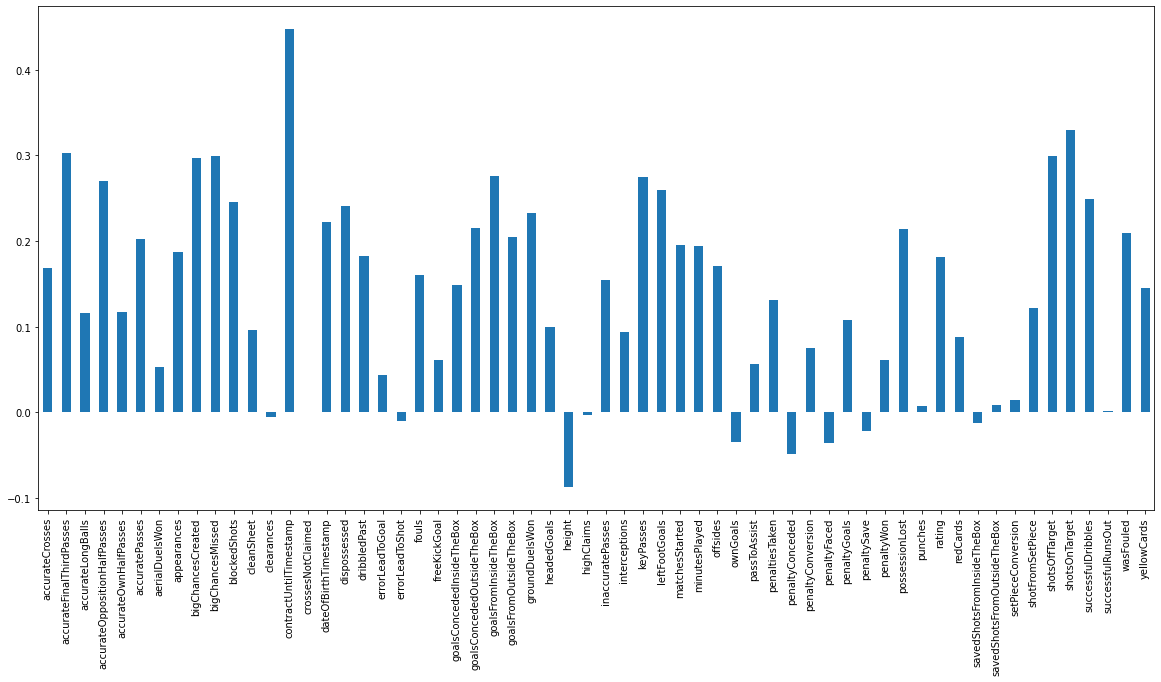

In [ ]:
correlation.plot(kind='bar')

In [ ]:
from scipy.sparse import csr_matrix
stats_sparse = csr_matrix(numeric_stats)

In [ ]:
from sklearn.neighbors import NearestNeighbors
model = NearestNeighbors(algorithm='brute', n_neighbors=5)
model.fit(stats_sparse)

NearestNeighbors(algorithm='brute')

In [ ]:
distance, similar_players_index = model.kneighbors(numeric_stats.loc[358554].values.reshape(1,-1))
similar_players = pd.DataFrame()
similar_players = df_players.loc[df_players.index[similar_players_index[0]]]
similar_players['distances'] = distance[0]

In [ ]:
similar_players

,accurateCrosses,accurateCrossesPercentage,accurateFinalThirdPasses,accurateLongBalls,accurateLongBallsPercentage,accurateOppositionHalfPasses,accurateOwnHalfPasses,accuratePasses,aerialDuelsWon,aerialDuelsWonPercentage,appearances,bigChancesCreated,bigChancesMissed,blockedShots,cleanSheet,clearances,contractUntilTimestamp,countryCode,countryName,crossesNotClaimed,dateOfBirthTimestamp,dispossessed,dribbledPast,errorLeadToGoal,errorLeadToShot,fouls,freeKickGoal,goalConversionPercentage,goalsConcededInsideTheBox,goalsConcededOutsideTheBox,goalsFromInsideTheBox,goalsFromOutsideTheBox,groundDuelsWon,groundDuelsWonPercentage,headedGoals,height,highClaims,inaccuratePasses,interceptions,keyPasses,league,leftFootGoals,matchesStarted,minutesPlayed,offsides,ownGoals,passToAssist,penaltiesTaken,penaltyConceded,penaltyConversion,penaltyFaced,penaltyGoals,penaltySave,penaltyWon,player.name,player.slug,player.userCount,position,positions,possessionLost,preferredFoot,proposedMarketCurrency,proposedMarketValue,punches,rating,redCards,retired,savedShotsFromInsideTheBox,savedShotsFromOutsideTheBox,setPieceConversion,shirtNumber,shotFromSetPiece,shotsOffTarget,shotsOnTarget,successfulDribbles,successfulDribblesPercentage,successfulRunsOut,team.id,team.name,team.shortName,team.slug,team.sport.id,team.sport.name,team.sport.slug,team.teamColors.primary,team.teamColors.secondary,team.teamColors.text,team.type,team.userCount,totalDuelsWon,totalDuelsWonPercentage,totalPasses,totalShots,wasFouled,yellowCards,distances
player.id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
358554,3,25.00,203,15,60.00,318,86,401,3,50.00,18,7,18,8,2,0,1.735603e+09,BR,Brazil,0,841363200.0,12,5,0,0,8,0,18.46,13,1,10,2,25,37.88,0,178.0,0,85,0,20,325,10,18,1491,12,0,0,4,0,75.0,0,3,0,0,Gabriel Barbosa,gabriel-barbosa,17817,F,[ST],154,Left,EUR,27000000.0,0,7.21,1,False,0,0,0.0,9.0,0,24,33,8,33.33,0,5981,Flamengo,Flamengo,flamengo,1,Football,football,#52b030,#52b030,#ffffff,0,0,28,38.89,486,65,14,4,3.919184e+01
1127439,30,24.39,343,34,41.98,700,421,1091,19,55.88,26,3,0,10,9,30,1.735603e+09,BR,Brazil,0,860976000.0,10,17,0,0,41,0,2.86,19,3,1,0,105,52.76,0,176.0,0,167,29,35,325,1,26,2286,3,0,0,0,0,0.0,0,0,0,0,Guilherme Arana,guilherme-arana,2761,D,"[DL, ML]",354,Left,EUR,11700000.0,0,7.08,0,False,0,0,0.0,13.0,0,13,12,32,53.33,0,1977,Atlético Mineiro,Atlético Mineiro,atletico-mineiro,1,Football,football,#52b030,#52b030,#ffffff,0,0,124,53.22,1258,35,40,7,2.487472e+07
1139775,1,9.09,116,9,37.50,248,156,403,5,35.71,16,2,0,4,3,7,1.735603e+09,PY,Paraguay,0,854064000.0,10,23,0,0,24,0,8.33,17,2,1,0,61,47.29,1,178.0,0,68,17,16,325,0,12,1011,0,0,0,0,0,0.0,0,0,0,0,Mathias Villasanti,villasanti-mathias,396,M,"[MC, DM]",115,Right,EUR,5200000.0,0,6.82,0,False,0,0,0.0,27.0,0,5,3,12,50.00,0,5926,Grêmio,Grêmio,gremio,1,Football,football,#52b030,#52b030,#ffffff,0,0,66,46.15,471,12,9,2,2.522995e+07
870760,0,0.00,111,50,58.14,254,274,528,14,63.64,12,0,0,2,3,7,1.735603e+09,BR,Brazil,0,837043200.0,14,15,0,0,23,0,0.00,9,0,0,0,61,53.51,0,180.0,0,89,15,9,325,0,11,953,0,0,0,0,0,0.0,0,0,0,0,Raul,raul,213,M,"[MC, DM]",126,Right,EUR,2100000.0,0,6.90,0,False,0,0,0.0,23.0,0,2,1,5,71.43,0,1999,Red Bull Bragantino,Red Bull Bragantino,red-bull-bragantino,1,Football,football,#52b030,#52b030,#ffffff,0,0,75,55.15,617,5,29,1,2.527197e+07
975207,1,8.33,90,7,58.33,168,85,252,71,50.00,28,0,6,8,0,12,1.733789e+09,BR,Brazil,0,845942400.0,19,7,0,0,55,0,6.67,12,3,2,1,63,41.18,1,195.0,0,103,6,13,325,0,14,1431,4,0,0,1,0,0.0,0,0,0,1,Cléber,cleber,238,F,[ST],200,Right,EUR,1100000.0,0,6.74,2,False,0,0,0.0,89.0,0,18,19,16,55.17,0,2001,Ceará,Ceará,ceara,1,Football,football,#52b030,#52b030,#ffffff,0,0,134,45.42,355,45,16,2,2.636420e+07
